In [35]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Tuple
import numpy as np
from scipy.signal import find_peaks
from sklearn.preprocessing import StandardScaler

import sys
sys.path.append("plotting")
import plotting_feature_extraction
import importlib
importlib.reload(plotting_feature_extraction)

<module 'plotting_feature_extraction' from '/home/frankwoods/Desktop/lassie/plotting/plotting_feature_extraction.py'>

In [36]:
curves_data = []
filename_list = []
for filename in os.listdir("data/cleaned_data"):
    df = pd.read_csv(f"data/cleaned_data/{filename}").drop(columns=["Unnamed: 0"])
    filename_list.append(filename)
    curves_data.append(df)
print(filename_list)
print(curves_data[0])

['_Fri_Aug__8_09_59_47_2025.csv', 'WS25_Aug5_Loc1A_T1_F10_0958.csv', 'WS23_L3_T1_P_16.csv', 'WS25_Aug5_Loc1A_T1_F15_1026.csv', '_Fri_Aug__8_10_04_59_2025.csv', 'WS25_Aug5_Loc1A_T1_F6_0930.csv', 'WS23_L2_T2_P_3.csv', 'WS23_L2_T1_P_4.csv', 'WS23_L1_T1_P_17.csv', 'WS23_L2_T2_P_2.csv', 'WS25_Aug8_Loc1A_WS_F7_0911_Attempt2.csv', 'WS23_L1_T1_P_8.csv', '_Fri_Aug__8_08_29_54_2025.csv', 'WS23_L1_T1_P_21.csv', 'WS23_L1_T1_P_16.csv', '_Fri_Aug__8_08_36_57_2025.csv', 'WS23_L3_T1_P_11.csv', 'WS25_Aug6_Loc1A_T1_F22_0653.csv', 'WS23_L3_T1_P_25.csv', 'WS23_L1_T1_P_5.csv', 'WS23_L3_T1_P_9.csv', 'WS23_L2_T1_P_14.csv', 'WS23_L2_T1_P_12.csv', 'WS23_L2_T2_P_4.csv', 'WS23_L2_T1_P_9.csv', 'WS25_Aug5_Loc1A_T1_F8_0955.csv', 'WS23_L2_T1_P_13.csv', 'WS23_L1_T1_P_23.csv', 'WS23_L1_T1_P_14.csv', 'WS23_L2_T1_P_6.csv', 'WS23_L2_T1_P_16.csv', '_Mon_Aug__4_20_05_03_2025.csv', '_Tue_Aug__5_05_52_11_2025.csv', 'WS23_L2_T2_P_0.csv', 'WS23_L2_T1_P_2.csv', 'WS23_L1_T1_P_7.csv', '_Tue_Aug__5_06_05_11_2025.csv', 'WS25_Aug6_L

# Find Curve Shape

In [37]:
def find_curve_shape(df):
    x = df['depth'].to_numpy()
    y = df['resistance'].to_numpy()
    # create evenly spaces points
    chord = np.linspace(df['resistance'].iloc[0], df['resistance'].iloc[-1], num=len(df['depth']))
    y_diff = y - chord # makes chord the x-axis, any y_points above chord are pos, below are neg
    return np.trapezoid(y=y_diff, x=x)

# Find Force-Drop

feature name first_third_slope is not an extracted feature
feature name second_third_slope is not an extracted feature
feature name third_third_slope is not an extracted feature
feature name q1 is not an extracted feature
feature name q2 is not an extracted feature


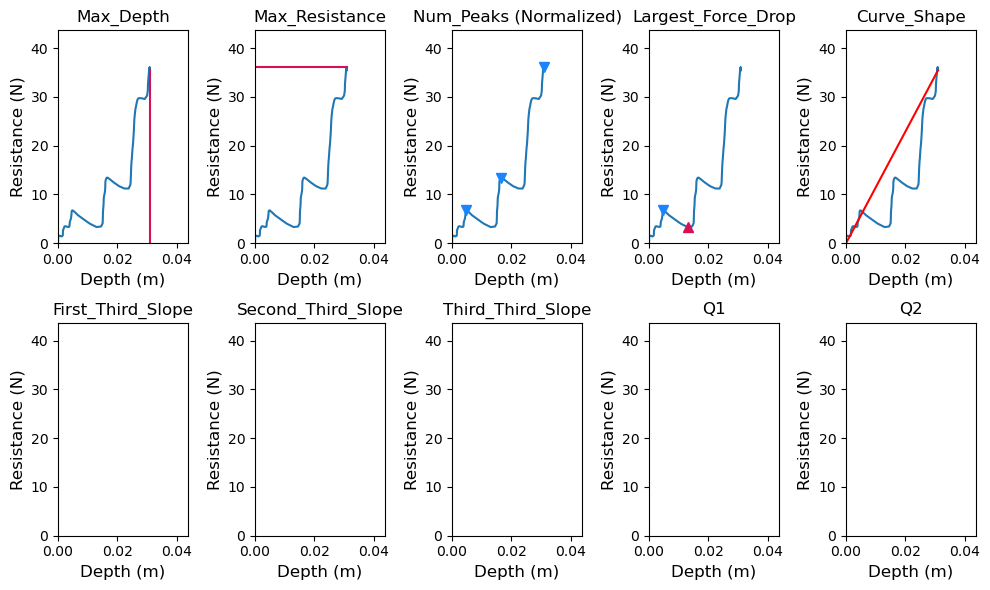

In [38]:
def find_force_drop_subranges(df: pd.DataFrame, percent_of_max_resistance: float):
    down_moves_subrange_list = []
    resistance_max = df['resistance'].max()
    min_drop_size = resistance_max * percent_of_max_resistance
    curr_peak_idx = 0
    curr_trough_idx = 0
    in_drop_subrange = 0 # bool

    for idx in range(1, len(df['resistance'])):
        curr_peak = df['resistance'].iloc[curr_peak_idx]
        curr_trough = df['resistance'].iloc[curr_trough_idx]
        curr_resistance = df['resistance'].iloc[idx]

        if curr_resistance >= curr_peak and in_drop_subrange:
            in_drop_subrange = 0
            down_moves_subrange_list.append((curr_peak_idx, curr_trough_idx))

        if curr_resistance >= curr_peak:
            curr_peak_idx = idx
            curr_trough_idx = idx
        elif curr_peak - curr_resistance >= min_drop_size and curr_resistance < curr_trough: 
            in_drop_subrange = 1
            curr_trough_idx = idx
    
    if in_drop_subrange: down_moves_subrange_list.append((curr_peak_idx, curr_trough_idx)) 
            
    return down_moves_subrange_list

def find_largest_force_drop(df: pd.DataFrame, subrange_list: List[Tuple]):
    curr_max_drop_size = 0
    curr_max_subrange_idxs = (0,0)
    for subrange_start, subrange_end in subrange_list:
        subrange_diff = df['resistance'].iloc[subrange_start] - df['resistance'].iloc[subrange_end]
        if subrange_diff > curr_max_drop_size: 
            curr_max_drop_size = subrange_diff
            curr_max_subrange_idxs = (subrange_start, subrange_end)
    return curr_max_drop_size, curr_max_subrange_idxs

def plot(curves_data: List[pd.DataFrame], plot_idx_range: List[int], title: str = 'Depth vs Resistance'):

    all_depth_resistance_data = pd.concat(curves_data, axis=0, ignore_index=True)
    gloabl_max_depth = all_depth_resistance_data['depth'].max()
    gloabl_max_resistance = all_depth_resistance_data['resistance'].max()

    for idx in plot_idx_range:

        print(f"plot idx: {idx}")

        df = curves_data[idx]
        percent = 0.1
        subranges = find_force_drop_subranges(df, percent)
        print(f"max_resistance: {df['resistance'].max()}")
        print(f"subranges: {[(float(df['resistance'].iloc[start]), float(df['resistance'].iloc[end])) for start, end in subranges]}")
   
        plt.figure(figsize=(5, 3))
        plt.xlim(0,gloabl_max_depth)
        plt.ylim(0,gloabl_max_resistance)
        plt.plot([0,df['depth'].max()], [0,df['resistance'].iloc[df['depth'].values.argmax()]], color='red')
        plt.plot([0,df['depth'].max()], [0,df['resistance'].iloc[df['depth'].values.argmax()]], color='red')
        plt.plot([0,df['depth'].max()], [0,df['resistance'].iloc[df['depth'].values.argmax()]], color='red')

        # Plot full depth vs resistance line
        plt.plot(df['depth'], df['resistance'],linestyle='-')
        plt.xlabel('Depth (m)')
        plt.ylabel('Resistance (N)')
        plt.title(f"{title} - Plot {idx}")
        # plt.grid(True)
        plt.tight_layout()
        plt.show()

plot_idx = plotting_feature_extraction.find_idxs(['_Fri_Aug__8_08_36_57_2025.csv'], filename_list)[0]
feature_to_plot_idx = {'max_depth':[plot_idx], 'max_resistance':[plot_idx], 'num_peaks':[plot_idx], 
                       'largest_force_drop':[plot_idx], 'curve_shape':[plot_idx], 
                       'first_third_slope':[plot_idx], 'second_third_slope':[plot_idx], 
                       'third_third_slope':[plot_idx], 'q1':[plot_idx], 'q2':[plot_idx]}
plotting_feature_extraction.plot_feature_selection(curves_data, feature_to_plot_idx)
# plot(curves_data, plot_idx_range=range(len(curves_data)))

# Choose Features
IMPORTANT: If you add variables here, you must add the names to the top of plotting.py file as well

In [39]:
def extract_simple_features(df):
    res = df["resistance"]
    dep = df["depth"]
    max_res_drop_val, max_res_drop_subrange_idxs = find_largest_force_drop(df, find_force_drop_subranges(df, 0.001))
    # print(max_res_drop_val, max_res_drop_subrange_idxs)
    return pd.DataFrame({
        # "overall_slope": [res.max() / dep.max()],
        "max_depth": [dep.max()],
        "max_resistance": [res.max()],
        "num_peaks": len(find_force_drop_subranges(df,0.1)) / dep.max(),
        "largest_force_drop": max_res_drop_val,
        "largest_force_drop_dep": dep.loc[max_res_drop_subrange_idxs[0]],
        "largest_force_drop_res": res.loc[max_res_drop_subrange_idxs[0]],
        "curve_shape": find_curve_shape(df),
        # "mean": res.mean(),
        # "first_half_slope": (res.quantile(0.50) - res.min()) / (dep.quantile(0.50) - dep.min()),
        # "second_half_slope": (res.max() - res.quantile(0.50)) / (dep.max() - dep.quantile(0.50)),
        "first_third_slope": (res.quantile(0.33) - res.min()) / (dep.quantile(0.33) - dep.min()),
        "second_third_slope": (res.quantile(0.66) - res.quantile(0.33)) / (dep.quantile(0.66) - dep.quantile(0.33)),
        "third_third_slope": (res.max() - res.quantile(0.66)) / (dep.max() - dep.quantile(0.66)),
        # "first_quarter_slope": (res.quantile(0.25) - res.min()) / (dep.quantile(0.25) - dep.min()),
        # "second_quarter_slope": (res.quantile(0.50) - res.quantile(0.25)) / (dep.quantile(0.50) - dep.quantile(0.25)),
        # "third_quarter_slope": (res.quantile(0.75) - res.quantile(0.50)) / (dep.quantile(0.75) - dep.quantile(0.50)),
        # "fourth_quarter_slope": (res.max() - res.quantile(0.75)) / (dep.max() - dep.quantile(0.75)),
        
        "q1": res.quantile(0.25),
        # "q2": res.quantile(0.50),
        "q3": res.quantile(0.75),
        # "skew": res.skew(), # measurs asymmetry of a distribution around it's mean
        # "kurtosis": res.kurt(), # descirbes tailedness or peakedness of a distribution
        # "largest_force_drop_res_level": find_largest_force_drop(df, find_force_drop_subranges(df, 0.15))[1]
    })

# shape (n,m) where n is number of df and m is extracted feaetures
representation_list = []
for i, df in enumerate(curves_data):
    extracted_simple_features = extract_simple_features(df)
    representation_list.append(extracted_simple_features)
print(f"example: {representation_list[0]}")

example:    max_depth  max_resistance  num_peaks  largest_force_drop  \
0   0.032757       34.502222        0.0            3.076177   

   largest_force_drop_dep  largest_force_drop_res  curve_shape  \
0                0.019628               22.069975     -0.12627   

   first_third_slope  second_third_slope  third_third_slope        q1  \
0         930.504483          829.737962        1389.439278  6.547399   

          q3  
0  19.460265  


# Correlation Matrix

In [40]:
representation_df = pd.concat(representation_list, axis=0, ignore_index=True)
corr_matrix = representation_df.corr()
print(corr_matrix)

                        max_depth  max_resistance  num_peaks  \
max_depth                1.000000       -0.421135   0.048623   
max_resistance          -0.421135        1.000000  -0.374136   
num_peaks                0.048623       -0.374136   1.000000   
largest_force_drop       0.476473       -0.112747   0.168721   
largest_force_drop_dep   0.542633       -0.171029  -0.019631   
largest_force_drop_res  -0.209231        0.353654  -0.161635   
curve_shape             -0.244384       -0.111131   0.051205   
first_third_slope       -0.587794        0.296906  -0.108899   
second_third_slope      -0.603229        0.328197  -0.140154   
third_third_slope       -0.608062        0.390356  -0.119565   
q1                      -0.290419        0.393042  -0.113213   
q3                      -0.464169        0.719166  -0.287220   

                        largest_force_drop  largest_force_drop_dep  \
max_depth                         0.476473                0.542633   
max_resistance             

# Visualize Extracted Features Histograms

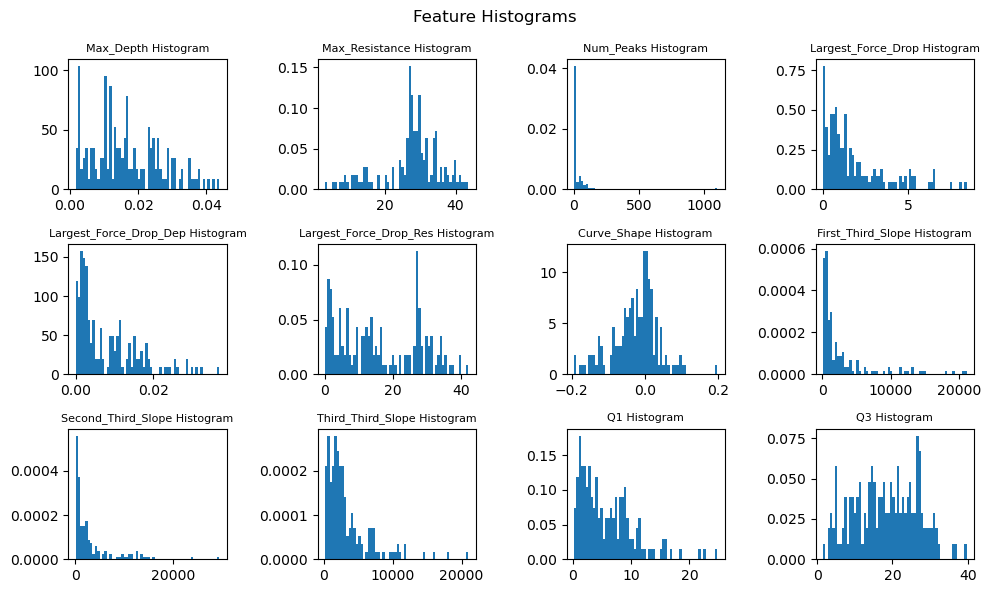

In [41]:
import math

def find_num_subplots(n):
    for i in range(int(math.sqrt(n)), 0, -1):
        if n % i == 0:
            # prime
            if i == 1 or n % i == 1: return find_num_subplots(n+1)
            else: return i, n // i

def plot_feature_dist(representation_df):
    # for col in representation_df.columns:
    x, y = find_num_subplots(len(representation_df.columns))
    fig, axs = plt.subplots(x,y,figsize=(10,6))
    fig.suptitle('Feature Histograms')
    for i, ax in enumerate(axs.flatten()):
        if i > len(representation_df.columns)-1: break
        col = representation_df.columns[i]
        ax.hist(representation_df[col], bins=60, density=True)
        ax.set_title(f"{col.title()} Histogram", fontsize=8)
    plt.tight_layout()
    plt.show()

plot_feature_dist(representation_df)

# Scale Features

   max_depth  max_resistance  num_peaks  largest_force_drop  \
0   1.574629        0.844172  -0.245575            0.691775   
1  -0.462706        0.122593  -0.245575           -0.684988   
2  -0.188058        0.842728  -0.245575           -0.527665   
3  -1.377186        0.133152  -0.245575           -0.883405   
4  -1.172758        0.020216  -0.245575           -0.892063   

   largest_force_drop_dep  largest_force_drop_res  curve_shape  \
0                1.452589                0.532791    -1.623511   
1               -0.716033               -1.094755    -0.412122   
2                0.755117                1.602815     0.933011   
3               -0.681304                1.093396     0.503459   
4               -0.457577                1.012317     0.115461   

   first_third_slope  second_third_slope  third_third_slope        q1  \
0          -0.458227           -0.506593          -0.570627  0.141104   
1          -0.506448           -0.231194           0.257599 -0.680037   
2    

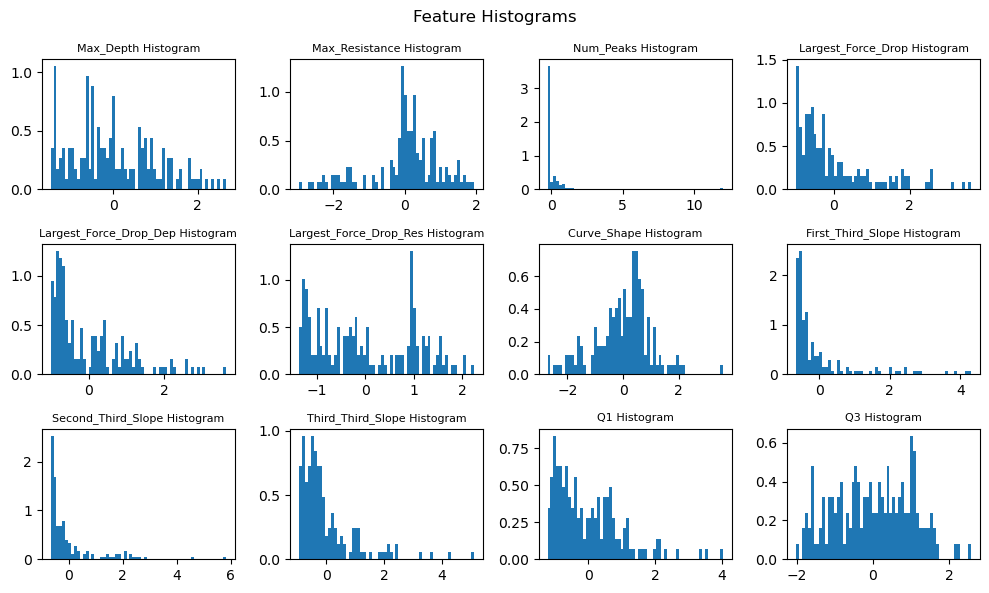

In [42]:
def transform_features(df):
    df = df.copy()  # avoid modifying original
    # Apply cube root to 'slope'
    if "overall_slope" in df.columns: df['overall_slope'] = np.log(df['overall_slope'])
    if "peaks" in df.columns: df['peaks'] = np.log(df['peaks'] + 1)
    if "peaks_value" in df.columns: df["peaks_value"] = np.log(df['peaks_value'])
    if 'force_drop' in df.columns: df['force_drop'] = np.log(df['force_drop'] + 1)
    if 'largest_force_drop_res_level' in df.columns: df['largest_force_drop_res_level'] = np.log(df['largest_force_drop_res_level'] + 1)
    # Standardize
    scaler = StandardScaler()
    df[df.columns] = scaler.fit_transform(df[df.columns])
    return df

scaled_representations = transform_features(representation_df)
print(scaled_representations[:5])
plot_feature_dist(scaled_representations)


In [43]:
corr_matrix = scaled_representations.corr()
print(corr_matrix)

                        max_depth  max_resistance  num_peaks  \
max_depth                1.000000       -0.421135   0.048623   
max_resistance          -0.421135        1.000000  -0.374136   
num_peaks                0.048623       -0.374136   1.000000   
largest_force_drop       0.476473       -0.112747   0.168721   
largest_force_drop_dep   0.542633       -0.171029  -0.019631   
largest_force_drop_res  -0.209231        0.353654  -0.161635   
curve_shape             -0.244384       -0.111131   0.051205   
first_third_slope       -0.587794        0.296906  -0.108899   
second_third_slope      -0.603229        0.328197  -0.140154   
third_third_slope       -0.608062        0.390356  -0.119565   
q1                      -0.290419        0.393042  -0.113213   
q3                      -0.464169        0.719166  -0.287220   

                        largest_force_drop  largest_force_drop_dep  \
max_depth                         0.476473                0.542633   
max_resistance             

# Add Meta-Data

### Add FeiFei's y_labels

In [44]:
scaled_representations['filenames'] = filename_list

feifeis_filename_to_labels = {'WS23_L2_T1_P_3.csv': 'biotic crust', 'WS23_L2_T1_P_4.csv': 'biotic crust', 'WS23_L2_T1_P_6.csv': 'biotic crust', 
    'WS23_L2_T1_P_7.csv': 'biotic crust with surface nodules', 'WS23_L2_T1_P_8.csv': 'biotic crust with surface nodules', 
    'WS23_L2_T1_P_11.csv': 'strata', 'WS23_L2_T1_P_12.csv': 'strata', 'WS23_L2_T1_P_13.csv': 'crusty ripple', 
    'WS23_L2_T1_P_14.csv': 'strata', 'WS23_L2_T1_P_15.csv': 'strata', 'WS23_L2_T1_P_16.csv': 'abiotic crust on top of strata', 
    'WS23_L3_T1_P_1.csv': 'abiotic crust', 'WS23_L3_T1_P_3.csv': 'strong biotic crust', 'WS23_L3_T1_P_4.csv': 'abiotic crust', 
    'WS23_L3_T1_P_5.csv': 'abiotic crust', 'WS23_L3_T1_P_6.csv': 'abiotic crust', 'WS23_L3_T1_P_7.csv': 'abiotic crust', 
    'WS23_L3_T1_P_8.csv': 'abiotic crust', 'WS23_L3_T1_P_9.csv': 'strata', 'WS23_L3_T1_P_10.csv': 'crusty ripple', 
    'WS23_L3_T1_P_11.csv': 'crusty ripple', 'WS23_L3_T1_P_12.csv': 'crusty ripple', 'WS23_L3_T1_P_13.csv': 'crusty ripple', 
    'WS23_L3_T1_P_15.csv': 'crusty ripple', 'WS23_L3_T1_P_16.csv': 'crusty ripple', 'WS23_L3_T1_P_17.csv': 'crusty ripple', 
    'WS23_L3_T1_P_18.csv': 'crusty ripple', 'WS23_L3_T1_P_19.csv': 'abiotic crust with surface nodule', 
    'WS23_L3_T1_P_20.csv': 'crusty ripple', 'WS23_L3_T1_P_21.csv': 'crusty ripple', 'WS23_L3_T1_P_22.csv': 'strata', 
    'WS23_L3_T1_P_23.csv': 'strata with loose sand on top'}

scaled_representations['feifeis_ylabels'] = scaled_representations['filenames'].map(feifeis_filename_to_labels)

### Add Liam's y_labels 

In [45]:
liams_filenames_to_ylabels = {'WS23_L3_T1_P_16.csv': 0, 'WS23_L1_T1_P_8.csv': 0, 'WS23_L3_T1_P_11.csv': 0, 'WS23_L2_T1_P_14.csv': 0, 'WS23_L1_T1_P_23.csv': 0, 
                       'WS23_L2_T2_P_0.csv': 0, 'WS23_L1_T1_P_7.csv': 0, 'WS23_L1_T1_P_12.csv': 0, 'WS23_L3_T1_P_33.csv': 0, 'WS23_L2_T1_P_10.csv': 0, 
                       'WS23_L1_T1_P_4.csv': 0, 'WS23_L1_T1_P_3.csv': 0, 'WS23_L3_T1_P_13.csv': 0, 'WS23_L1_T1_P_22.csv': 0, 'WS23_L1_T1_P_10.csv': 0, 
                       'WS23_L3_T1_P_12.csv': 0, 'WS23_L1_T1_P_13.csv': 0, 'WS23_L3_T1_P_20.csv': 0, 'WS23_L3_T1_P_31.csv': 0, 'WS23_L2_T1_P_4.csv': 1, 
                       'WS23_L2_T2_P_2.csv': 1, 'WS23_L2_T2_P_4.csv': 1, 'WS23_L1_T1_P_15.csv': 1, 'WS23_L3_T1_P_3.csv': 1, 'WS23_L3_T1_P_18.csv': 1, 
                       'WS23_L1_T1_P_17.csv': 2, 'WS23_L3_T1_P_9.csv': 2, 'WS23_L2_T1_P_12.csv': 2, 'WS23_L1_T1_P_11.csv': 2, 'WS23_L3_T1_P_22.csv': 2, 
                       'WS23_L2_T1_P_15.csv': 2, 'WS23_L1_T1_P_20.csv': 2, 'WS23_L2_T1_P_11.csv': 2, 'WS23_L1_T1_P_18.csv': 2, 'WS23_L1_T1_P_21.csv': 3, 
                       'WS23_L1_T1_P_9.csv': 3, 'WS23_L3_T1_P_23.csv': 3, 'WS23_L1_T1_P_16.csv': 4, 'WS23_L1_T1_P_14.csv': 4, 'WS23_L3_T1_P_15.csv': 4, 
                       'WS23_L3_T1_P_25.csv': 5, 'WS23_L1_T1_P_5.csv': 5, 'WS23_L3_T1_P_27.csv': 5, 'WS23_L1_T1_P_1.csv': 5, 'WS23_L3_T1_P_26.csv': 5, 
                       'WS23_L2_T1_P_9.csv': 6, 'WS23_L3_T1_P_2.csv': 6, 'WS23_L2_T2_P_1.csv': 6, 'WS23_L3_T1_P_30.csv': 6, 'WS23_L2_T1_P_0.csv': 6, 
                       'WS23_L2_T1_P_13.csv': 7, 'WS23_L3_T1_P_17.csv': 7, 'WS23_L3_T1_P_21.csv': 7, 'WS23_L2_T1_P_6.csv': 8, 'WS23_L3_T1_P_29.csv': 8, 
                       'WS23_L2_T1_P_8.csv': 8, 'WS23_L3_T1_P_6.csv': 8, 'WS23_L3_T1_P_0.csv': 8, 'WS23_L2_T1_P_3.csv': 8, 'WS23_L3_T1_P_5.csv': 8, 
                       'WS23_L3_T1_P_24.csv': 8, 'WS23_L1_T1_P_0.csv': 8, 'WS23_L1_T1_P_19.csv': 8, 'WS23_L3_T1_P_19.csv': 8, 'WS23_L2_T1_P_17.csv': 8, 
                       'WS23_L1_T1_P_2.csv': 8, 'WS23_L2_T1_P_7.csv': 8, 'WS23_L2_T2_P_3.csv': 9, 'WS23_L2_T1_P_16.csv': 9, 'WS23_L3_T1_P_4.csv': 9, 
                       'WS23_L1_T1_P_6.csv': 9, 'WS23_L3_T1_P_8.csv': 9, 'WS23_L3_T1_P_7.csv': 9, 'WS23_L2_T1_P_2.csv': 10, 'WS23_L2_T1_P_5.csv': 10, 
                       'WS23_L3_T1_P_32.csv': 10, 'WS23_L3_T1_P_1.csv': 10, 'WS23_L2_T1_P_1.csv': 10, 'WS23_L3_T1_P_14.csv': 11, 'WS23_L3_T1_P_10.csv': 11}

scaled_representations['liams_ylabels'] = scaled_representations['filenames'].map(liams_filenames_to_ylabels)

### Add Marion's y_labels

In [46]:
marions_filenames_to_ylabels = {
    "WS23_L2_T1_P_0.csv": 'LS', "WS23_L2_T1_P_1.csv": 'LS', "WS23_L2_T1_P_2.csv": 'LS', "WS23_L2_T1_P_3.csv": 'ES-D', "WS23_L2_T1_P_4.csv": "LS", "WS23_L2_T1_P_5.csv": "ES-D",
    "WS23_L2_T1_P_6.csv": "ES-D", "WS23_L2_T1_P_7.csv": "ES-D", "WS23_L2_T1_P_8.csv": "ES-DB", "WS23_L2_T1_P_9.csv": "ES-S", "WS23_L2_T1_P_10.csv": "ES-D", "WS23_L2_T1_P_11.csv": 'ES-D',
    "WS23_L2_T1_P_12.csv": 'ES-S', "WS23_L2_T1_P_13.csv": 'ES-D', "WS23_L2_T1_P_14.csv": 'ES-S', "WS23_L2_T1_P_15.csv": 'ES-D', "WS23_L2_T1_P_16.csv": 'ES-DB', "WS23_L2_T1_P_17.csv": 'ES-S',

    "WS23_L3_T1_P_0.csv": 'LS', "WS23_L3_T1_P_1.csv": 'ES-B', "WS23_L3_T1_P_2.csv": 'ES-B', "WS23_L3_T1_P_3.csv": 'ES-S',
    "WS23_L3_T1_P_4.csv": 'ES-B', "WS23_L3_T1_P_5.csv": 'ES-B', "WS23_L3_T1_P_6.csv": 'ES-BW', "WS23_L3_T1_P_7.csv": 'ES-B',
    "WS23_L3_T1_P_8.csv": 'ES-BW', "WS23_L3_T1_P_9.csv": 'F', "WS23_L3_T1_P_10.csv": 'ES-D', "WS23_L3_T1_P_11.csv": 'ES',
    "WS23_L3_T1_P_12.csv": 'F', "WS23_L3_T1_P_13.csv": 'F', "WS23_L3_T1_P_14.csv": 'ES-D', "WS23_L3_T1_P_15.csv": 'ES-D',
    "WS23_L3_T1_P_16.csv": 'ES-B', "WS23_L3_T1_P_17.csv": 'ES', "WS23_L3_T1_P_18.csv": 'ES-S-Plates', "WS23_L3_T1_P_19.csv": 'ES-S-Plates',
    "WS23_L3_T1_P_20.csv": 'LS/F', "WS23_L3_T1_P_21.csv": 'ES', "WS23_L3_T1_P_22.csv": 'ES', "WS23_L3_T1_P_23.csv": 'LS'
}

scaled_representations['marions_ylabels'] = scaled_representations['filenames'].map(marions_filenames_to_ylabels)


# Add Marion's y_label corrections

In [47]:
marions_filenames_to_ylabels_deduction = {
    "WS23_L2_T1_P_0.csv": 'LS', "WS23_L2_T1_P_1.csv": 'LS', "WS23_L2_T1_P_2.csv": 'LS', "WS23_L2_T1_P_3.csv": 'ES-D', "WS23_L2_T1_P_4.csv": "LS", "WS23_L2_T1_P_5.csv": "ES-D",
    "WS23_L2_T1_P_6.csv": "ES-D", "WS23_L2_T1_P_7.csv": "ES-D", "WS23_L2_T1_P_8.csv": "ES-B", "WS23_L2_T1_P_9.csv": "ES-S", "WS23_L2_T1_P_10.csv": "ES-D", "WS23_L2_T1_P_11.csv": 'ES-D',
    "WS23_L2_T1_P_12.csv": 'ES-S', "WS23_L2_T1_P_13.csv": 'ES-D', "WS23_L2_T1_P_14.csv": 'ES-S', "WS23_L2_T1_P_15.csv": 'ES-D', "WS23_L2_T1_P_16.csv": 'ES-B', "WS23_L2_T1_P_17.csv": 'ES-S',

    "WS23_L3_T1_P_0.csv": 'LS', "WS23_L3_T1_P_1.csv": 'ES-B', "WS23_L3_T1_P_2.csv": 'ES-B', "WS23_L3_T1_P_3.csv": 'ES-S',
    "WS23_L3_T1_P_4.csv": 'ES-B', "WS23_L3_T1_P_5.csv": 'ES-B', "WS23_L3_T1_P_6.csv": 'ES-B', "WS23_L3_T1_P_7.csv": 'ES-B',
    "WS23_L3_T1_P_8.csv": 'ES-B', "WS23_L3_T1_P_9.csv": 'F', "WS23_L3_T1_P_10.csv": 'ES-D', "WS23_L3_T1_P_11.csv": 'ES',
    "WS23_L3_T1_P_12.csv": 'F', "WS23_L3_T1_P_13.csv": 'F', "WS23_L3_T1_P_14.csv": 'ES-D', "WS23_L3_T1_P_15.csv": 'ES-D',
    "WS23_L3_T1_P_16.csv": 'ES-B', "WS23_L3_T1_P_17.csv": 'ES', "WS23_L3_T1_P_18.csv": 'ES-S', "WS23_L3_T1_P_19.csv": 'ES-S',
    "WS23_L3_T1_P_20.csv": 'F', "WS23_L3_T1_P_21.csv": 'ES', "WS23_L3_T1_P_22.csv": 'ES', "WS23_L3_T1_P_23.csv": 'LS'
}

scaled_representations['marions_ylabels_deduction'] = scaled_representations['filenames'].map(marions_filenames_to_ylabels_deduction)


### Add feet from dune

In [48]:
filenames_list = ['WS23_L1_T1_P_0.csv', 'WS23_L1_T1_P_1.csv', 'WS23_L1_T1_P_2.csv', 'WS23_L1_T1_P_3.csv', 'WS23_L1_T1_P_4.csv', 'WS23_L1_T1_P_5.csv', 'WS23_L1_T1_P_6.csv', 'WS23_L1_T1_P_7.csv', 'WS23_L1_T1_P_8.csv', 'WS23_L1_T1_P_9.csv', 'WS23_L1_T1_P_10.csv', 'WS23_L1_T1_P_11.csv', 'WS23_L1_T1_P_12.csv', 'WS23_L1_T1_P_13.csv', 'WS23_L1_T1_P_14.csv', 'WS23_L1_T1_P_15.csv', 'WS23_L1_T1_P_16.csv', 'WS23_L1_T1_P_17.csv', 'WS23_L1_T1_P_18.csv', 'WS23_L1_T1_P_19.csv', 'WS23_L2_T1_P_0.csv', 'WS23_L2_T1_P_1.csv', 'WS23_L2_T1_P_2.csv', 'WS23_L2_T1_P_3.csv', 'WS23_L2_T1_P_4.csv', 'WS23_L2_T1_P_5.csv', 'WS23_L2_T1_P_6.csv', 'WS23_L2_T1_P_7.csv', 'WS23_L2_T1_P_8.csv', 'WS23_L2_T1_P_9.csv', 'WS23_L2_T1_P_10.csv', 'WS23_L2_T1_P_11.csv', 'WS23_L2_T1_P_12.csv', 'WS23_L2_T1_P_13.csv', 'WS23_L2_T1_P_14.csv', 'WS23_L2_T1_P_15.csv', 'WS23_L2_T1_P_16.csv', 'WS23_L2_T1_P_17.csv', 'WS23_L2_T2_P_0.csv', 'WS23_L2_T2_P_1.csv', 'WS23_L2_T2_P_2.csv', 'WS23_L2_T2_P_3.csv', 'WS23_L2_T2_P_4.csv', 'WS23_L3_T1_P_0.csv', 'WS23_L3_T1_P_1.csv', 'WS23_L3_T1_P_2.csv', 'WS23_L3_T1_P_3.csv', 'WS23_L3_T1_P_4.csv', 'WS23_L3_T1_P_5.csv', 'WS23_L3_T1_P_6.csv', 'WS23_L3_T1_P_7.csv', 'WS23_L3_T1_P_8.csv', 'WS23_L3_T1_P_9.csv', 'WS23_L3_T1_P_10.csv', 'WS23_L3_T1_P_11.csv', 'WS23_L3_T1_P_12.csv', 'WS23_L3_T1_P_13.csv', 'WS23_L3_T1_P_14.csv', 'WS23_L3_T1_P_15.csv', 'WS23_L3_T1_P_16.csv', 'WS23_L3_T1_P_17.csv', 'WS23_L3_T1_P_18.csv', 'WS23_L3_T1_P_19.csv', 'WS23_L3_T1_P_20.csv', 'WS23_L3_T1_P_21.csv', 'WS23_L3_T1_P_22.csv', 'WS23_L3_T1_P_23.csv']
distances_list = [0, 3, 5.5, 10.5, 12, 14, 38, 41.5, 44, 47, 51, 90, 93, 96, 102, 107, 151, 152, 153, 170, 3.25, 0, 6, 13, 16, 19, 24, 64, 67, 72, 75, 87, 88, 88, 91, 95, 112, 116, 0, 4, 11, 20, 27, 0, 10, 16, 19, 40, 49, 98, 160, 161, 187, 188, 229, 253, 254, 255, 308, 317, 318, 353, 357, 363, 369, 384, 389]

filenames_to_distances = dict(zip(filenames_list, distances_list))
scaled_representations['distances'] = scaled_representations['filenames'].map(filenames_to_distances)

# Save representation

In [49]:
scaled_representations.to_csv(f"data/features.csv", index=False)
print(scaled_representations)

     max_depth  max_resistance  num_peaks  largest_force_drop  \
0     1.574629        0.844172  -0.245575            0.691775   
1    -0.462706        0.122593  -0.245575           -0.684988   
2    -0.188058        0.842728  -0.245575           -0.527665   
3    -1.377186        0.133152  -0.245575           -0.883405   
4    -1.172758        0.020216  -0.245575           -0.892063   
..         ...             ...        ...                 ...   
159  -1.396180       -0.079736  -0.245575           -0.688067   
160  -1.317743       -0.063820  -0.245575           -0.901600   
161  -0.450357       -1.859579  -0.245575           -0.623301   
162   2.495262       -2.361286   0.809647            0.097167   
163   0.992332       -1.587123  -0.245575           -0.601868   

     largest_force_drop_dep  largest_force_drop_res  curve_shape  \
0                  1.452589                0.532791    -1.623511   
1                 -0.716033               -1.094755    -0.412122   
2              